In [ ]:
%%bash 
# pip3 install --upgrade pandas-gbq
# Restart the kernel after you run this 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

## Set up project and bucket 

In [2]:
project_id = !gcloud info |tr -d '[]' | awk '/project:/ {print $2}'
project_id = project_id[0]

In [3]:
BUCKET = 'autotel-{}'.format(project_id)

In [4]:
!gsutil mb -l us-central1 gs://{BUCKET}

Creating gs://autotel_gad-playground-212407/...


## Explore the data 

In [5]:
# This query uses a public dataset we created, we pay for the storage, you pay for the queries you run!
SQL = '''
SELECT * FROM `gad-playground-212407.doit_intl_autotel_public.sample_view` WHERE RAND() < 0.01
'''

In [6]:
df = pd.read_gbq(query=SQL, project_id=project_id, dialect='standard')
df.head()

,timestamp,latitude,longitude,total_cars,carsList
0,2018-12-01 14:21:05.533755+00:00,32.059834,34.772457,4,"[82, 107, 197, 253]"
1,2018-11-26 09:31:29.240941+00:00,32.044160,34.769970,4,"[42, 198, 217, 230]"
2,2019-09-16 19:39:33.232326+00:00,32.059730,34.768910,4,"[40, 89, 183, 151]"
3,2018-12-01 12:57:38.102425+00:00,32.059834,34.772457,4,"[82, 107, 197, 253]"
4,2018-12-02 10:50:13.140418+00:00,32.103400,34.805900,7,"[84, 144, 158, 161, 167, 168, 216]"


/usr/local/lib/python3.5/dist-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


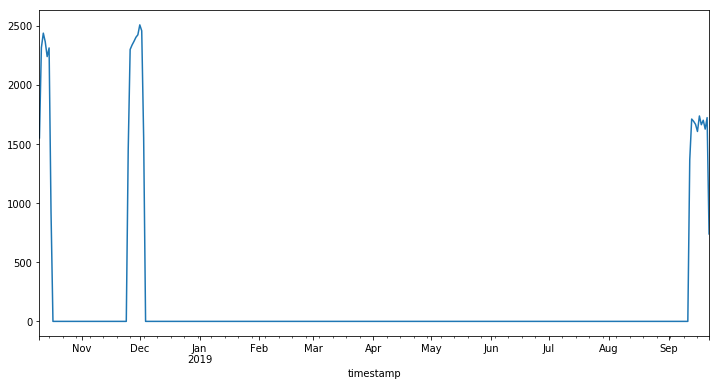

In [7]:
df.set_index('timestamp').groupby(pd.Grouper(freq='1D')).count()['total_cars'].plot(figsize=(12,6))
plt.show()

In [8]:
df_grouped = df.set_index('timestamp').groupby(pd.Grouper(freq='1min')).agg({'total_cars':'sum'})
df_grouped.index = df_grouped.index.tz_convert('Asia/Jerusalem')
df_grouped.head()

,total_cars
timestamp,
2018-10-10 10:35:00+03:00,1
2018-10-10 10:36:00+03:00,0
2018-10-10 10:37:00+03:00,0
2018-10-10 10:38:00+03:00,2
2018-10-10 10:39:00+03:00,0


In [9]:
df_grouped = df_grouped.reset_index()

In [10]:
# Break down date
df_grouped['weekday'] = df_grouped['timestamp'].dt.day_name()
df_grouped['hour'] = df_grouped['timestamp'].dt.hour
df_grouped = df_grouped[df_grouped['total_cars'] > 0]

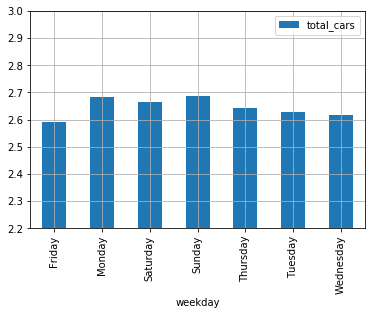

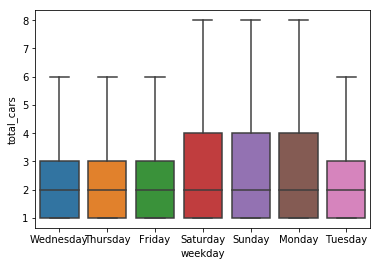

In [11]:
df_grouped.groupby('weekday').agg({'total_cars':'mean'}).plot(kind='bar', ylim=(2.2, 3.0))
plt.grid()
plt.show()

sns.boxplot(x=df_grouped['weekday'], y=df_grouped['total_cars'], data=df_grouped, showfliers=False)
plt.show()

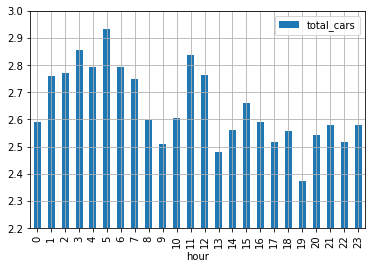

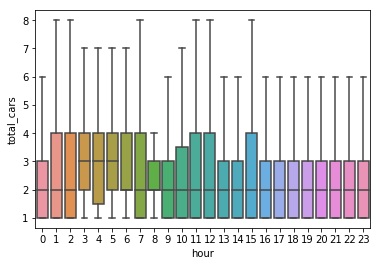

In [12]:
df_grouped.groupby('hour').agg({'total_cars':'mean'}).plot(kind='bar', ylim=(2.2, 3.0))
plt.grid()
plt.show()

sns.boxplot(x=df_grouped['hour'], y=df_grouped['total_cars'], data=df_grouped, showfliers=False)
plt.show()

In [13]:
# Start manipulating data using BigQuery
query_join_geomerty = '''
WITH
  car_locs AS (SELECT * FROM `gad-playground-212407.doit_intl_autotel_public.sample_view`),
  tlv_nbhd AS (SELECT * FROM `gad-playground-212407.doit_intl_autotel_public.tel_aviv_neighborhood`)
SELECT car_locs.*, tlv_nbhd.neighborhood_name FROM car_locs
JOIN tlv_nbhd
ON ST_WITHIN(ST_GEOGPOINT(car_locs.longitude, car_locs.latitude),ST_GeogFromText(tlv_nbhd.area_polygon))
LIMIT 10
'''

In [14]:
df_neighborhood = pd.read_gbq(query=query_join_geomerty, project_id=project_id, dialect='standard')
df_neighborhood.head()

,timestamp,latitude,longitude,total_cars,carsList,neighborhood_name
0,2019-09-22 07:42:03.184035+00:00,32.109362,34.819260,0,[],Hadar-Yosef
1,2019-09-12 22:39:02.335543+00:00,32.080801,34.768594,0,[],Old North - Southern part
2,2018-11-25 20:12:48.589778+00:00,32.073391,34.778651,0,[],Old North - Southern part
3,2019-09-16 14:39:03.098699+00:00,32.083389,34.769872,0,[],Old North - Southern part
4,2019-09-16 22:39:03.119787+00:00,32.079825,34.774450,0,[],Old North - Southern part


In [15]:
query_group_by_neighborhood = '''
WITH
  car_locs AS (SELECT * FROM `gad-playground-212407.doit_intl_autotel_public.sample_view`),
  tlv_nbhd AS (SELECT * FROM `gad-playground-212407.doit_intl_autotel_public.tel_aviv_neighborhood`)
SELECT 
    TIMESTAMP_TRUNC(timestamp, MINUTE) timestamp,
    neighborhood_name,
    SUM(total_cars) total_cars
 FROM(
            SELECT car_locs.*, tlv_nbhd.neighborhood_name FROM car_locs
            JOIN tlv_nbhd
            ON ST_WITHIN(ST_GEOGPOINT(car_locs.longitude, car_locs.latitude),ST_GeogFromText(tlv_nbhd.area_polygon)
            )) 
GROUP BY 1,2
LIMIT 100
'''

In [16]:
df_neighborhood = pd.read_gbq(query=query_group_by_neighborhood, project_id=project_id, dialect='standard')
df_neighborhood.head()

,timestamp,neighborhood_name,total_cars
0,2018-11-27 15:22:00+00:00,Jaffa D,0
1,2018-11-27 21:50:00+00:00,Jaffa D,0
2,2018-10-12 16:29:00+00:00,Jaffa D,1
3,2018-11-26 09:23:00+00:00,Jaffa D,0
4,2018-11-30 04:20:00+00:00,Jaffa D,1


## Prepare data for AutoML 

In [29]:
automl_query_dataset = '''
WITH car_counts AS (WITH
  car_locs AS (SELECT * FROM `gad-playground-212407.doit_intl_autotel_public.sample_view`),
  tlv_nbhd AS (SELECT * FROM `gad-playground-212407.doit_intl_autotel_public.tel_aviv_neighborhood`)
SELECT 
    TIMESTAMP_TRUNC(timestamp, MINUTE) timestamp,
    neighborhood_name,
    SUM(total_cars) total_cars
 FROM(
            SELECT car_locs.*, tlv_nbhd.neighborhood_name FROM car_locs
            JOIN tlv_nbhd
            ON ST_WITHIN(ST_GEOGPOINT(car_locs.longitude, car_locs.latitude),ST_GeogFromText(tlv_nbhd.area_polygon)
            )) GROUP BY 1,2), 
            neighborhood_features AS( SELECT * FROM `gad-playground-212407.doit_intl_autotel_public.neighborhood_features`)
SELECT 
         TIMESTAMP_TRUNC(timestamp, hour) timestamp,
         neighborhood_name,
         AVG(total_cars) available_cars,
         AVG(age5to14 ) age5to14,
         AVG(age15to19) age15to19,
         AVG(age20to29) age20to29,
         AVG(age30to34) age30to34,
         AVG(age35to49) age35to49,
         AVG(age50to64) age50to64,
         AVG(total_kingrtn) total_kingrtn,  
         AVG(total_hotels) total_hotels
    FROM(
    SELECT      
         total_cars,  
         age5to14,
         age15to19,
         age20to29,
         age30to34,
         age35to49,
         age50to64,
         total_kingrtn, 
         total_hotels,
         car_counts.neighborhood_name,
         timestamp 
        
    FROM car_counts LEFT JOIN neighborhood_features ON
    car_counts.neighborhood_name = neighborhood_features.neighborhood_name)
    GROUP BY 1,2
'''

In [30]:
df_all = pd.read_gbq(query=automl_query_dataset, project_id=project_id, dialect='standard')
df_all.head()

,timestamp,neighborhood_name,available_cars,age5to14,age15to19,age20to29,age30to34,age35to49,age50to64,total_kingrtn,total_hotels
0,2019-09-19 23:00:00+00:00,Kfir,1.0,13.2,6.5,14.0,7.6,19.3,18.3,5.0,NaN
1,2019-09-14 03:00:00+00:00,Kfir,1.0,13.2,6.5,14.0,7.6,19.3,18.3,5.0,NaN
2,2019-09-17 06:00:00+00:00,Kiryat Shaul,1.0,18.5,6.9,9.6,4.8,23.4,15.0,2.0,NaN
3,2019-09-16 05:00:00+00:00,Kiryat Shaul,1.0,18.5,6.9,9.6,4.8,23.4,15.0,2.0,NaN
4,2019-09-21 12:00:00+00:00,Kiryat Shaul,3.0,18.5,6.9,9.6,4.8,23.4,15.0,2.0,NaN


In [31]:
df_all.to_csv('./dataset_automl.csv', index=None)

In [32]:
!gsutil cp dataset_automl.csv gs://{BUCKET}/data/

Copying file://dataset_automl.csv [Content-Type=text/csv]...
/ [1 files][  3.1 MiB/  3.1 MiB]                                                
Operation completed over 1 objects/3.1 MiB.                                      


## Prepare data for AI-Platform

In [35]:
aiplatform_query_dataset = '''
WITH car_counts AS (WITH
  car_locs AS (SELECT * FROM `gad-playground-212407.doit_intl_autotel_public.sample_view`),
  tlv_nbhd AS (SELECT * FROM `gad-playground-212407.doit_intl_autotel_public.tel_aviv_neighborhood`)
SELECT 
    TIMESTAMP_TRUNC(timestamp, MINUTE) timestamp,
    neighborhood_name,
    SUM(total_cars) total_cars
 FROM(
            SELECT car_locs.*, tlv_nbhd.neighborhood_name FROM car_locs
            JOIN tlv_nbhd
            ON ST_WITHIN(ST_GEOGPOINT(car_locs.longitude, car_locs.latitude),ST_GeogFromText(tlv_nbhd.area_polygon)
            )) GROUP BY 1,2), 
            neighborhood_features AS( SELECT * FROM `gad-playground-212407.doit_intl_autotel_public.neighborhood_features`)
            
SELECT 
         AVG(total_cars) available_cars,
         TIMESTAMP_TRUNC(timestamp, hour) timestamp,
         neighborhood_name,
         AVG(age5to14 ) age5to14,
         AVG(age15to19) age15to19,
         AVG(age20to29) age20to29,
         AVG(age30to34) age30to34,
         AVG(age35to49) age35to49,
         AVG(age50to64) age50to64,
         AVG(total_kingrtn) total_kingrtn,  
         AVG(total_hotels) total_hotels,
         AVG(hour) hour, 
         AVG(MINUTE) minute, 
         AVG(weekday) weekday
    FROM(
    SELECT      
         total_cars,  
         age5to14,
         age15to19,
         age20to29,
         age30to34,
         age35to49,
         age50to64,
         total_kingrtn, 
         total_hotels,
         car_counts.neighborhood_name,
         EXTRACT(HOUR FROM timestamp) hour,
         EXTRACT(MINUTE FROM timestamp) minute, 
         EXTRACT(DAYOFWEEK FROM timestamp) weekday,
         timestamp 
        
FROM car_counts LEFT JOIN neighborhood_features ON
car_counts.neighborhood_name = neighborhood_features.neighborhood_name)
GROUP BY 2,3
'''

In [36]:
df_all_aip = pd.read_gbq(query=aiplatform_query_dataset, project_id=project_id, dialect='standard')
df_all_aip.head()

,available_cars,timestamp,neighborhood_name,age5to14,age15to19,age20to29,age30to34,age35to49,age50to64,total_kingrtn,total_hotels,hour,minute,weekday
0,1.0,2019-09-20 19:00:00+00:00,South Park,14.5,6.5,13.0,7.5,21.0,17.0,NaN,NaN,19.0,28.500000,6.0
1,1.0,2019-09-22 01:00:00+00:00,South Park,14.5,6.5,13.0,7.5,21.0,17.0,NaN,NaN,1.0,28.500000,1.0
2,2.0,2019-09-20 10:00:00+00:00,Kfir,13.2,6.5,14.0,7.6,19.3,18.3,5.0,NaN,10.0,28.500000,6.0
3,1.0,2018-10-15 05:00:00+00:00,South Park,14.5,6.5,13.0,7.5,21.0,17.0,NaN,NaN,5.0,30.380952,2.0
4,2.0,2019-09-20 15:00:00+00:00,Kfir,13.2,6.5,14.0,7.6,19.3,18.3,5.0,NaN,15.0,28.500000,6.0


In [37]:
target = 'available_cars'
numerics = ['age5to14', 'age15to19', 'age20to29', 'age30to34', 'age35to49', 'age50to64', 'total_kingrtn', 'total_hotels']
categoricals = ['hour', 'minute', 'weekday']

In [38]:
df_all_aip.loc[:,target] = df_all_aip.loc[:,target].astype(float)
df_all_aip.loc[:,numerics] = df_all_aip.loc[:,numerics].astype(float)
df_all_aip.loc[:,categoricals] = df_all_aip.loc[:,categoricals].astype(int)

In [39]:
df_train = df_all_aip[df_all_aip['timestamp'] < '2019-09-10'].drop(['timestamp','neighborhood_name'] , axis=1)
df_val = df_all_aip[df_all_aip['timestamp'] >= '2019-09-10'].drop(['timestamp','neighborhood_name'], axis=1)

In [40]:
df_train.to_csv('./df_train.csv', index=None, header=None)
df_val.to_csv('./df_val.csv', index=None, header=None)

In [41]:
!gsutil cp df_train.csv gs://{BUCKET}/data/
!gsutil cp df_val.csv gs://{BUCKET}/data/

Copying file://df_train.csv [Content-Type=text/csv]...
/ [1 files][  1.1 MiB/  1.1 MiB]                                                
Operation completed over 1 objects/1.1 MiB.                                      
Copying file://df_val.csv [Content-Type=text/csv]...
/ [1 files][762.8 KiB/762.8 KiB]                                                
Operation completed over 1 objects/762.8 KiB.                                    


In [42]:
df_all_aip_2 = df_all_aip.copy()

In [43]:
df_all_aip_2['data_split'] = 'TRAIN'
df_all_aip_2['data_split'].loc[df_all_aip['timestamp'] > '2019-09-10'] = 'VALIDATE'
df_all_aip_2['data_split'].loc[df_all_aip['timestamp'] > '2019-09-17'] = 'TEST'

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [44]:
df_all_aip_2.to_csv('./df_train_header.csv', index=None)

In [45]:
!gsutil cp df_train_header.csv gs://{BUCKET}/data/

Copying file://df_train_header.csv [Content-Type=text/csv]...
/ [1 files][  3.6 MiB/  3.6 MiB]                                                
Operation completed over 1 objects/3.6 MiB.                                      
